In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from skimage.transform import resize
from random import randint

%matplotlib inline

In [3]:
labels = pd.read_csv('train.csv')

In [4]:
labels.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [5]:
rows = labels.shape[0]
rows

333415

In [6]:
labels["fine_grained"] = labels["ClassId"].apply(lambda x: len(x.split("_"))) > 1
labels['main_class'] = labels['ClassId'].apply(lambda x: int(x.split('_')[0]))
fine_grained_percentage = labels['fine_grained'].mean() * 100
labels['num_attributes'] = labels['ClassId'].apply(lambda x: int(len(x.split('_')[1:])))
histogram_num_attributes = labels.groupby(['num_attributes'], sort=True).size().reset_index(name='Count')
histogram_main_class = labels.groupby(['main_class'], sort=True).size().reset_index(name='Count')
histogram_num_attributes['Percentage'] = histogram_num_attributes['Count']/rows * 100
histogram_main_class['Percentage'] = histogram_main_class['Count']/rows * 100
histogram_main_class

,main_class,Count,Percentage
0,0,6161,1.847847
1,1,16550,4.963784
2,2,1494,0.448090
3,3,1107,0.332019
4,4,7833,2.349324
5,5,720,0.215947
6,6,12415,3.723588
7,7,2756,0.826597
8,8,5046,1.513429
9,9,3124,0.936970


Text(0.5, 1.0, 'Main Class Histogram')

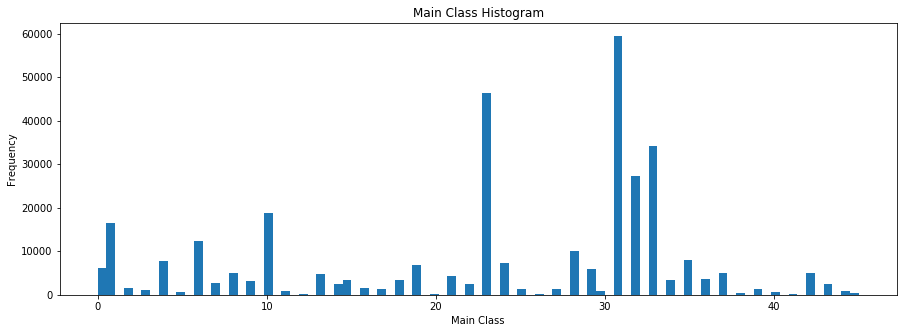

In [7]:
plt.figure(figsize=(15,5))
n, bins, patches = plt.hist(x=labels['main_class'], bins='auto')
plt.xlabel('Main Class')
plt.ylabel('Frequency')
plt.title('Main Class Histogram')

In [8]:
width_height = labels.groupby(['ImageId','Height', 'Width'])

width_height = pd.DataFrame(width_height.size().reset_index(name = "Group_Count"))

width_height.shape[0]

45625

Text(0.5, 1.0, 'Width distribution')

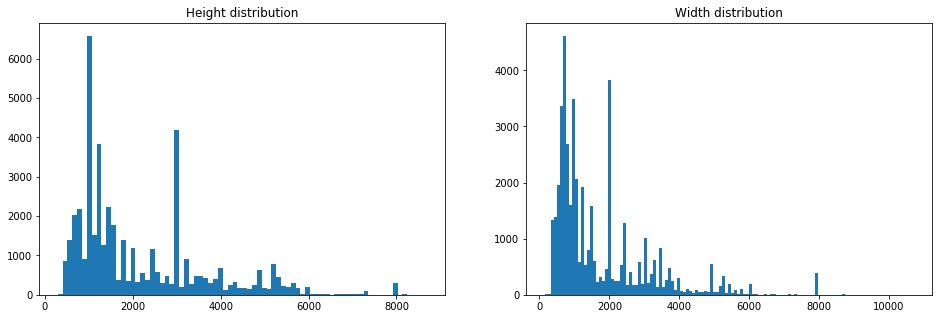

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(width_height.Height, bins='auto')
ax1.set_title("Height distribution")
ax2.hist(width_height.Width, bins='auto')
ax2.set_title("Width distribution")

In [10]:
def get_img(img):
    img = cv.imread('_train/'+img)
    height, width, channels = img.shape
    print(height, width, channels)
    return img

In [11]:
max_height_jpg = str(labels.iloc[[labels['Height'].idxmax()]]['ImageId'].values[0])
max_height = str(labels.iloc[[labels['Height'].idxmax()]]['Height'].values[0])
max_height_jpg, max_height

('057929711659b06bfdfa48150c2c5231.jpg', '8688')

8688 5792 3


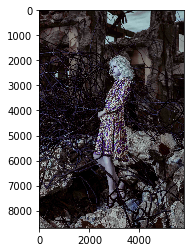

In [12]:
img = get_img(max_height_jpg)
height, width, channels = img.shape
plt.imshow(img)

In [13]:
min_height_jpg = str(labels.iloc[[labels['Height'].idxmin()]]['ImageId'].values[0])
min_height = str(labels.iloc[[labels['Height'].idxmin()]]['Height'].values[0])
min_height_jpg, min_height

('671cb261d0f1e522c1af51e2630b8631.jpg', '296')

296 331 3


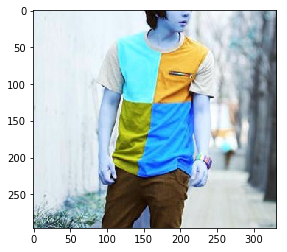

In [14]:
img = get_img(min_height_jpg)
height, width, channels = img.shape
plt.imshow(img)

In [15]:
def get_masks(image_id, resized_shape=(512, 512)):
    masks = dict()
    temp = labels[labels.ImageId == image_id]
    for i in range(temp.shape[0]):
        width = temp.iloc[i].Width
        height = temp.iloc[i].Height
        class_id = temp.iloc[i].ClassId.split()[0]
        mask_encoded = temp.iloc[i].EncodedPixels.split()
        mask = [0] * (width*height)
        for j in range(0, len(mask_encoded), 2):
            mask[int(mask_encoded[j]): int(mask_encoded[j])+int(mask_encoded[j+1])] = [1]*int(mask_encoded[j+1])
        mask = np.fliplr(np.flip(np.rot90(np.array(mask).reshape((width, height)))))
        mask = cv.resize(mask,resized_shape, interpolation = cv.INTER_NEAREST)
        masks[int(class_id)] = mask
    return masks

In [17]:
def random_images(n=5):
    masks = {}
    for i in range(0,n):
        idx = randint(0,rows)
        imageId = labels.iloc[idx]['ImageId']
        mask = get_masks(imageId)
        masks[imageId] = mask
    return masks

In [19]:
masks = random_images()
len(masks)

5

## Paper images

In [20]:
def get_min_and_masks(in_mask):
    _length = []
    _masks = []
    for element in list(in_mask):
        print(type(element.values()))
        _length.append(len(element))
        _masks.append(list(element.values()))
        
    _min =  min(_length)
    flatten_masks = []
    [flatten_masks.append(item) for sublist in _masks for item in sublist[:_min]]
    return _min , flatten_masks

In [21]:
def draw_images(mask):
    rows = len(mask.keys())
    cols_min, values  = get_min_and_masks(mask.values())
    cols_min += 1
    images = list(mask.keys())

    fig, ax = plt.subplots(rows, cols_min, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0)
    
    for row in range(rows):
        for col in range(1, cols_min):
            ax[row, col].xaxis.set_major_locator(plt.NullLocator())
            ax[row, col].yaxis.set_major_locator(plt.NullLocator())
            ax[row, col].imshow(values[row * (cols_min-1) + (col - 1)], cmap="viridis")  
    
    for idx in range(rows):
        ax[idx, 0].xaxis.set_major_locator(plt.NullLocator())
        ax[idx, 0].yaxis.set_major_locator(plt.NullLocator())
        ax[idx, 0].imshow(get_img(images[idx]))
    
    fig.savefig('masks.png' , bbox_inches = 'tight', pad_inches = 0)

<class 'dict_values'>
<class 'dict_values'>
<class 'dict_values'>
<class 'dict_values'>
<class 'dict_values'>
3000 2000 3
1763 1168 3
1500 887 3
2048 1365 3
800 535 3


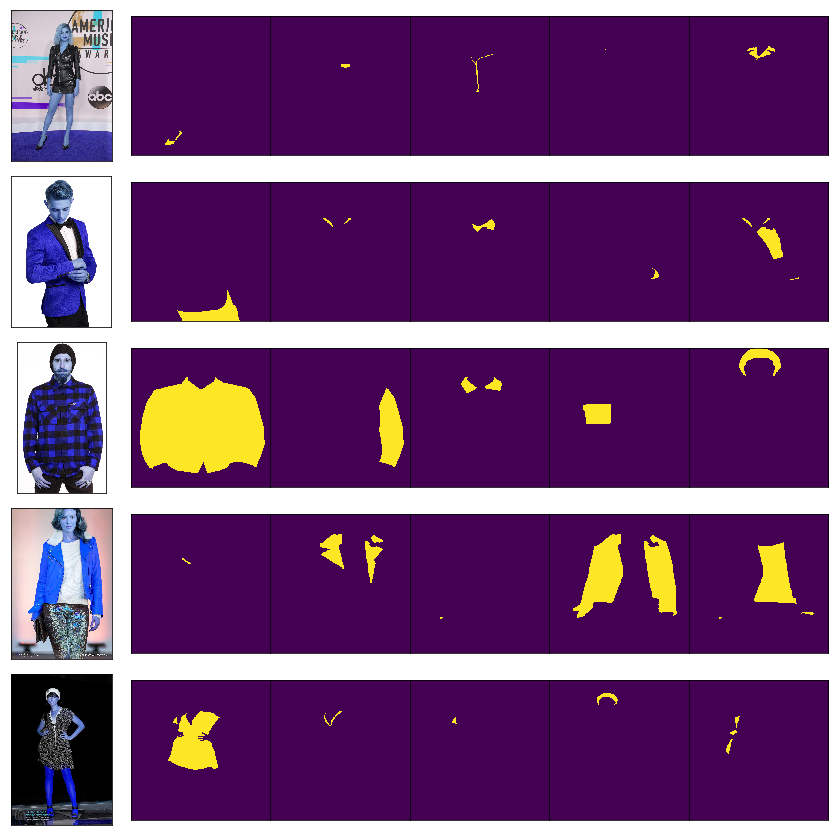

In [22]:
draw_images(masks)

In [23]:
_labels = os.listdir('masks')

In [26]:
def replace_ext(path):
    return path[:-4] + '.jpg'

In [24]:
def get_images(labels):
    images = []
    for label in labels:
        images.append(replace_ext(label))
    return images

In [27]:
images = get_images(_labels)

In [28]:
def load_image(path, mask=False, shape=(256,256)):
    if mask:
        img = cv.imread(path, 0)
        img = cv.resize(img, shape, interpolation = cv.INTER_NEAREST)
    else:
        img = cv.imread(path)
        img = cv.resize(img, shape, interpolation = cv.INTER_AREA)
    return img

In [35]:
def draw_images(num_imgs, images, labels, train_path , mask_path ):
    
    rows = 2
    cols = num_imgs
    
    fig, ax = plt.subplots(rows, cols, figsize=(16,8), gridspec_kw = {'wspace':0, 'hspace':0})
    
    for row in range(rows-1):
        for col in range(cols):
            ax[row, col].xaxis.set_major_locator(plt.NullLocator())
            ax[row, col].yaxis.set_major_locator(plt.NullLocator())
            ax[row, col].imshow(load_image( train_path + images[col]), aspect='auto')
            
            ax[row + 1, col].xaxis.set_major_locator(plt.NullLocator())
            ax[row + 1, col].yaxis.set_major_locator(plt.NullLocator())
            ax[row + 1, col].imshow(load_image( mask_path + labels[col], mask=True), aspect='auto')
    
   
    fig.show()
    #Uncomment to save image
    fig.savefig('full_masks.png' , bbox_inches = 'tight', pad_inches = 0)

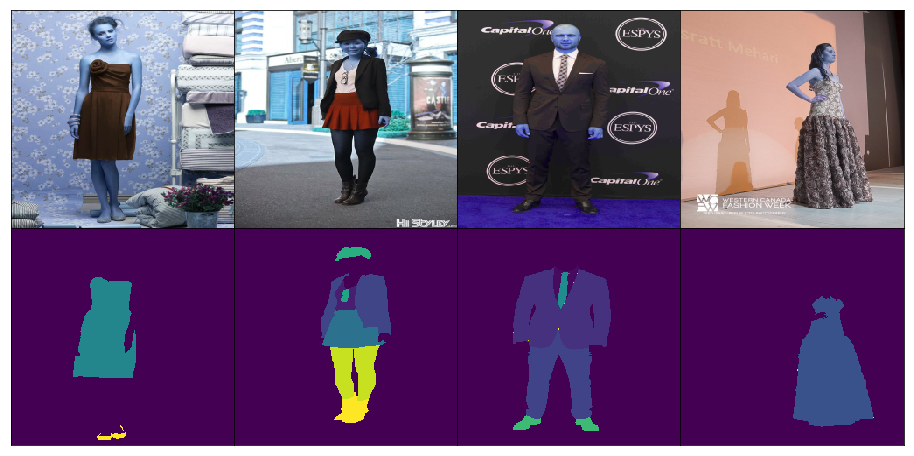

In [38]:
draw_images(4, images[2:], _labels[2:], '_train' + os.sep , 'masks' + os.sep)

## Save masks on disk

In [14]:
import h5py
from tqdm import tqdm

In [15]:
def get_training_example(values, width, height, resized_shape, class_id):
    
    mask_encoded = values.split()
    mask = [0] * (width*height)
    
    for j in range(0, len(mask_encoded), 2):
        
        mask[int(mask_encoded[j]): int(mask_encoded[j])+int(mask_encoded[j+1])] = [class_id]*int(mask_encoded[j+1])
    
    mask = np.fliplr(np.flip(np.rot90(np.array(mask , dtype = 'uint8').reshape((width, height)))))

    return mask

In [16]:
labels.head()

,ImageId,EncodedPixels,Height,Width,ClassId,fine_grained,main_class,num_attributes
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,False,6,0
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,False,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,False,28,0
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,False,31,0
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,False,32,0


In [14]:
imgid_pix = labels[["ImageId" , "EncodedPixels", "main_class" , "Height" , "Width"]].groupby(["ImageId"])
imgid_pix

In [137]:
mask_file = h5py.File("./masks_h5/train.h5" , "w")

In [18]:
n_images = len(labels["ImageId"].unique())
class_freq  = sorted(list(histogram_main_class["Count"]))
n_images , class_freq[:10], len(class_freq)

(45625, [112, 135, 152, 274, 335, 528, 588, 720, 874, 922], 46)

In [19]:
def takeSecond(element):
    return element[1]

In [20]:
def get_full_mask(masks):
    m ,  n = masks[0].shape
    full_mask = np.zeros((m,n))
    priority = []
    for idx , mask in enumerate(masks):
        priority.append((idx, np.count_nonzero(mask == 0 ))) 
    #if the mask has many nonzero elements it'll be draw first
    priority.sort(key=takeSecond, reverse=True)
    for element in priority:
        row_idx, col_idx = np.where( masks[element[0]] != 0)
        for pos in range(len(row_idx)):
            full_mask[row_idx[pos] , col_idx[pos]] = masks[element[0] , row_idx[pos], col_idx[pos]]
        
    return full_mask        

In [ ]:
def save_images_on_disk(imgid_pix):
    i = 0
    for element in tqdm(imgid_pix):
        key = element[0]

        _class = element[1]["main_class"] 
        value = element[1]["EncodedPixels"]
        width, height = element[1]["Width"] , element[1]["Height"]
        training_examples = []
        for i in range(i , i + len(value)):
            x = value[i]
            example = get_training_example(value[i] , width[i] , height[i], (512, 512), _class[i] + 1)
            training_examples.append(example) 

        full_mask = get_full_mask(np.array(training_examples))

        cv.imwrite('masks' + os.sep + key[:-4] +'.png' , full_mask)       
        i+=1







  0%|          | 0/45625 [00:00<?, ?it/s]





  0%|          | 1/45625 [00:20<257:43:48, 20.34s/it]





  0%|          | 2/45625 [00:23<190:33:29, 15.04s/it]





  0%|          | 3/45625 [00:24<140:54:57, 11.12s/it]





  0%|          | 4/45625 [00:25<99:10:13,  7.83s/it] 





  0%|          | 5/45625 [00:25<70:06:27,  5.53s/it]





  0%|          | 6/45625 [00:25<50:24:09,  3.98s/it]





  0%|          | 7/45625 [00:25<36:19:24,  2.87s/it]





  0%|          | 8/45625 [00:27<30:02:54,  2.37s/it]





  0%|          | 9/45625 [00:39<66:52:50,  5.28s/it]





  0%|          | 10/45625 [00:39<48:27:01,  3.82s/it]





  0%|          | 11/45625 [00:41<42:51:11,  3.38s/it]





  0%|          | 12/45625 [00:42<31:14:13,  2.47s/it]





  0%|          | 13/45625 [00:42<23:45:45,  1.88s/it]





  0%|          | 14/45625 [00:46<30:29:46,  2.41s/it]





  0%|          | 15/45625 [00:47<24:09:57,  1.91s/it]





  0%|          | 16/45625 [00:47<17:53:25,  1.41s/it]





  0%|   

  0%|          | 217/45625 [11:31<9:40:05,  1.30it/s] 





  0%|          | 218/45625 [11:31<8:52:14,  1.42it/s]





  0%|          | 219/45625 [11:44<52:49:39,  4.19s/it]





  0%|          | 220/45625 [11:44<38:43:45,  3.07s/it]





  0%|          | 221/45625 [11:51<54:32:21,  4.32s/it]





  0%|          | 222/45625 [11:52<41:33:31,  3.30s/it]





  0%|          | 223/45625 [11:55<40:06:25,  3.18s/it]





  0%|          | 224/45625 [11:59<40:41:19,  3.23s/it]





  0%|          | 226/45625 [12:00<31:30:11,  2.50s/it]





  0%|          | 227/45625 [12:04<37:03:17,  2.94s/it]





  0%|          | 228/45625 [12:05<30:44:46,  2.44s/it]





  1%|          | 229/45625 [12:06<22:25:08,  1.78s/it]





  1%|          | 230/45625 [12:06<16:59:17,  1.35s/it]





  1%|          | 231/45625 [12:20<65:40:35,  5.21s/it]





  1%|          | 232/45625 [12:26<67:01:53,  5.32s/it]





  1%|          | 233/45625 [12:34<76:57:16,  6.10s/it]





  1%|          | 234/45625 [12:35<57:57:3

  1%|          | 426/45625 [26:00<82:04:27,  6.54s/it]





  1%|          | 427/45625 [26:09<89:27:22,  7.13s/it]





  1%|          | 428/45625 [26:14<81:29:49,  6.49s/it]





  1%|          | 429/45625 [26:25<100:02:48,  7.97s/it]





  1%|          | 430/45625 [26:26<72:11:48,  5.75s/it] 





  1%|          | 431/45625 [26:27<55:20:37,  4.41s/it]





  1%|          | 432/45625 [26:49<119:10:49,  9.49s/it]





  1%|          | 433/45625 [26:49<84:11:51,  6.71s/it] 





  1%|          | 434/45625 [26:50<62:04:14,  4.94s/it]





  1%|          | 435/45625 [26:55<62:00:09,  4.94s/it]





  1%|          | 436/45625 [26:56<47:55:13,  3.82s/it]





  1%|          | 437/45625 [26:57<36:43:42,  2.93s/it]





  1%|          | 438/45625 [27:00<40:17:27,  3.21s/it]





  1%|          | 439/45625 [27:10<63:17:12,  5.04s/it]





  1%|          | 440/45625 [27:15<65:34:09,  5.22s/it]





  1%|          | 441/45625 [27:16<47:01:32,  3.75s/it]





  1%|          | 442/45625 [27:19<47

  1%|▏         | 638/45625 [39:40<43:32:40,  3.48s/it]





  1%|▏         | 639/45625 [39:52<77:13:14,  6.18s/it]





  1%|▏         | 640/45625 [39:53<57:43:38,  4.62s/it]





  1%|▏         | 641/45625 [39:56<51:30:18,  4.12s/it]





  1%|▏         | 642/45625 [40:00<49:36:43,  3.97s/it]





  1%|▏         | 643/45625 [40:00<36:25:54,  2.92s/it]





  1%|▏         | 644/45625 [40:01<28:22:09,  2.27s/it]





  1%|▏         | 645/45625 [40:01<21:59:12,  1.76s/it]





  1%|▏         | 646/45625 [40:10<46:22:41,  3.71s/it]





  1%|▏         | 647/45625 [40:10<34:36:25,  2.77s/it]





  1%|▏         | 648/45625 [40:10<24:45:24,  1.98s/it]





  1%|▏         | 649/45625 [40:12<23:51:40,  1.91s/it]





  1%|▏         | 650/45625 [40:14<22:33:57,  1.81s/it]





  1%|▏         | 651/45625 [40:14<17:07:35,  1.37s/it]





  1%|▏         | 652/45625 [40:22<40:06:13,  3.21s/it]





  1%|▏         | 653/45625 [40:22<30:46:51,  2.46s/it]





  1%|▏         | 654/45625 [40:31<54:12:

  2%|▏         | 849/45625 [56:25<11:29:44,  1.08it/s]





  2%|▏         | 850/45625 [56:31<28:52:56,  2.32s/it]





  2%|▏         | 851/45625 [56:38<48:28:46,  3.90s/it]





  2%|▏         | 852/45625 [56:45<57:53:52,  4.66s/it]





  2%|▏         | 853/45625 [56:50<61:21:41,  4.93s/it]





  2%|▏         | 854/45625 [56:51<45:51:11,  3.69s/it]





  2%|▏         | 855/45625 [57:00<66:21:04,  5.34s/it]





  2%|▏         | 856/45625 [57:02<52:01:15,  4.18s/it]





  2%|▏         | 857/45625 [57:07<56:27:33,  4.54s/it]





  2%|▏         | 858/45625 [57:09<46:19:21,  3.73s/it]





  2%|▏         | 860/45625 [57:16<45:20:45,  3.65s/it]





  2%|▏         | 861/45625 [57:17<35:41:41,  2.87s/it]





  2%|▏         | 862/45625 [57:19<32:18:58,  2.60s/it]





  2%|▏         | 863/45625 [57:19<24:31:15,  1.97s/it]





  2%|▏         | 864/45625 [57:22<28:50:11,  2.32s/it]





  2%|▏         | 865/45625 [57:26<33:20:20,  2.68s/it]





  2%|▏         | 866/45625 [57:52<121:36

  2%|▏         | 1054/45625 [1:10:57<14:23:36,  1.16s/it]





  2%|▏         | 1055/45625 [1:10:57<11:38:53,  1.06it/s]





  2%|▏         | 1056/45625 [1:10:59<13:22:49,  1.08s/it]





  2%|▏         | 1057/45625 [1:11:04<29:37:20,  2.39s/it]





  2%|▏         | 1058/45625 [1:11:07<30:46:42,  2.49s/it]





  2%|▏         | 1059/45625 [1:11:07<23:28:16,  1.90s/it]





  2%|▏         | 1060/45625 [1:11:08<19:11:51,  1.55s/it]





  2%|▏         | 1061/45625 [1:11:09<16:03:39,  1.30s/it]





  2%|▏         | 1062/45625 [1:11:09<12:27:22,  1.01s/it]





  2%|▏         | 1063/45625 [1:11:10<10:11:44,  1.21it/s]





  2%|▏         | 1064/45625 [1:11:11<12:10:41,  1.02it/s]





  2%|▏         | 1065/45625 [1:11:11<10:36:58,  1.17it/s]





  2%|▏         | 1067/45625 [1:11:13<10:05:05,  1.23it/s]





  2%|▏         | 1068/45625 [1:11:13<8:27:34,  1.46it/s] 





  2%|▏         | 1069/45625 [1:11:14<9:12:59,  1.34it/s]





  2%|▏         | 1070/45625 [1:11:15<8:34:35,  1.44it/s]

  3%|▎         | 1158/45625 [1:17:29<27:24:10,  2.22s/it]





  3%|▎         | 1159/45625 [1:17:29<21:20:06,  1.73s/it]





  3%|▎         | 1160/45625 [1:17:30<18:29:36,  1.50s/it]





  3%|▎         | 1161/45625 [1:17:32<19:18:49,  1.56s/it]





  3%|▎         | 1162/45625 [1:17:32<14:12:08,  1.15s/it]





  3%|▎         | 1163/45625 [1:17:44<53:58:23,  4.37s/it]





  3%|▎         | 1164/45625 [1:17:44<38:20:56,  3.11s/it]





  3%|▎         | 1165/45625 [1:17:45<28:37:59,  2.32s/it]





  3%|▎         | 1166/45625 [1:17:58<67:54:09,  5.50s/it]





  3%|▎         | 1167/45625 [1:17:58<48:45:07,  3.95s/it]





  3%|▎         | 1168/45625 [1:18:05<60:51:14,  4.93s/it]





  3%|▎         | 1169/45625 [1:18:06<43:49:48,  3.55s/it]





  3%|▎         | 1170/45625 [1:18:06<31:36:30,  2.56s/it]





  3%|▎         | 1171/45625 [1:18:08<29:26:08,  2.38s/it]





  3%|▎         | 1172/45625 [1:18:15<46:31:00,  3.77s/it]





  3%|▎         | 1173/45625 [1:18:27<77:47:59,  6.30s/i

  3%|▎         | 1261/45625 [1:24:21<41:16:43,  3.35s/it]





  3%|▎         | 1262/45625 [1:24:23<34:41:05,  2.81s/it]





  3%|▎         | 1263/45625 [1:24:25<31:22:46,  2.55s/it]





  3%|▎         | 1264/45625 [1:24:26<28:37:21,  2.32s/it]





  3%|▎         | 1265/45625 [1:24:27<22:00:56,  1.79s/it]





  3%|▎         | 1266/45625 [1:24:28<19:30:37,  1.58s/it]





  3%|▎         | 1267/45625 [1:24:30<19:23:43,  1.57s/it]





  3%|▎         | 1268/45625 [1:24:30<15:48:22,  1.28s/it]





  3%|▎         | 1269/45625 [1:24:31<15:50:53,  1.29s/it]





  3%|▎         | 1270/45625 [1:24:32<13:33:26,  1.10s/it]





  3%|▎         | 1271/45625 [1:24:33<11:02:49,  1.12it/s]





  3%|▎         | 1272/45625 [1:24:33<9:58:19,  1.24it/s] 





  3%|▎         | 1273/45625 [1:24:34<8:35:27,  1.43it/s]





  3%|▎         | 1274/45625 [1:24:34<8:00:35,  1.54it/s]





  3%|▎         | 1275/45625 [1:24:35<10:36:33,  1.16it/s]





  3%|▎         | 1276/45625 [1:24:38<15:22:00,  1.25s/it]

  3%|▎         | 1467/45625 [1:35:05<25:58:11,  2.12s/it]





  3%|▎         | 1468/45625 [1:35:05<19:18:44,  1.57s/it]





  3%|▎         | 1469/45625 [1:35:09<25:52:33,  2.11s/it]





  3%|▎         | 1470/45625 [1:35:09<18:58:24,  1.55s/it]





  3%|▎         | 1472/45625 [1:35:16<25:52:18,  2.11s/it]





  3%|▎         | 1473/45625 [1:35:17<22:20:10,  1.82s/it]





  3%|▎         | 1474/45625 [1:35:18<19:54:23,  1.62s/it]





  3%|▎         | 1475/45625 [1:35:19<17:47:53,  1.45s/it]





  3%|▎         | 1476/45625 [1:35:20<14:14:29,  1.16s/it]





  3%|▎         | 1477/45625 [1:35:20<11:09:34,  1.10it/s]





  3%|▎         | 1478/45625 [1:35:22<15:39:34,  1.28s/it]





  3%|▎         | 1479/45625 [1:35:22<11:39:26,  1.05it/s]





  3%|▎         | 1480/45625 [1:35:23<11:04:38,  1.11it/s]





  3%|▎         | 1481/45625 [1:35:35<51:12:18,  4.18s/it]





  3%|▎         | 1482/45625 [1:35:39<51:02:19,  4.16s/it]





  3%|▎         | 1483/45625 [1:35:49<73:49:24,  6.02s/i

  4%|▎         | 1673/45625 [1:49:07<94:13:54,  7.72s/it]





  4%|▎         | 1674/45625 [1:49:08<67:53:09,  5.56s/it]





  4%|▎         | 1675/45625 [1:49:12<65:28:51,  5.36s/it]





  4%|▎         | 1676/45625 [1:49:14<49:55:15,  4.09s/it]





  4%|▎         | 1677/45625 [1:49:16<44:40:32,  3.66s/it]





  4%|▎         | 1678/45625 [1:49:17<32:57:52,  2.70s/it]





  4%|▎         | 1679/45625 [1:49:17<24:46:22,  2.03s/it]





  4%|▎         | 1680/45625 [1:49:17<18:28:57,  1.51s/it]





  4%|▎         | 1681/45625 [1:49:24<37:44:32,  3.09s/it]





  4%|▎         | 1682/45625 [1:49:25<29:26:49,  2.41s/it]





  4%|▎         | 1683/45625 [1:49:26<22:16:45,  1.83s/it]





  4%|▎         | 1684/45625 [1:49:26<17:24:10,  1.43s/it]





  4%|▎         | 1685/45625 [1:49:40<63:54:05,  5.24s/it]





  4%|▎         | 1686/45625 [1:49:44<57:25:24,  4.70s/it]





  4%|▎         | 1687/45625 [1:49:48<55:05:51,  4.51s/it]





  4%|▎         | 1688/45625 [1:50:03<94:51:23,  7.77s/i

  4%|▍         | 1878/45625 [2:00:35<83:04:51,  6.84s/it] 





  4%|▍         | 1879/45625 [2:00:37<62:33:07,  5.15s/it]





  4%|▍         | 1880/45625 [2:00:41<60:01:54,  4.94s/it]





  4%|▍         | 1881/45625 [2:00:52<80:49:39,  6.65s/it]





  4%|▍         | 1882/45625 [2:00:53<62:02:05,  5.11s/it]





  4%|▍         | 1883/45625 [2:01:00<67:57:53,  5.59s/it]





  4%|▍         | 1884/45625 [2:01:00<48:53:40,  4.02s/it]





  4%|▍         | 1885/45625 [2:01:01<35:17:49,  2.91s/it]





  4%|▍         | 1886/45625 [2:01:01<27:48:16,  2.29s/it]





  4%|▍         | 1888/45625 [2:01:02<20:05:31,  1.65s/it]





  4%|▍         | 1889/45625 [2:01:18<73:28:50,  6.05s/it]





  4%|▍         | 1890/45625 [2:01:24<73:49:29,  6.08s/it]





  4%|▍         | 1891/45625 [2:01:25<52:55:29,  4.36s/it]





  4%|▍         | 1892/45625 [2:01:26<43:48:43,  3.61s/it]





  4%|▍         | 1893/45625 [2:01:27<32:50:49,  2.70s/it]





  4%|▍         | 1894/45625 [2:01:27<23:36:51,  1.94s/

  5%|▍         | 2084/45625 [2:13:54<21:03:55,  1.74s/it]





  5%|▍         | 2085/45625 [2:14:00<37:43:04,  3.12s/it]





  5%|▍         | 2086/45625 [2:14:04<39:15:19,  3.25s/it]





  5%|▍         | 2087/45625 [2:14:18<78:23:02,  6.48s/it]





  5%|▍         | 2088/45625 [2:14:19<58:46:41,  4.86s/it]





  5%|▍         | 2089/45625 [2:14:20<46:05:21,  3.81s/it]





  5%|▍         | 2090/45625 [2:14:20<33:19:54,  2.76s/it]





  5%|▍         | 2091/45625 [2:14:25<38:19:19,  3.17s/it]





  5%|▍         | 2092/45625 [2:14:25<27:58:44,  2.31s/it]





  5%|▍         | 2093/45625 [2:14:30<37:46:04,  3.12s/it]





  5%|▍         | 2094/45625 [2:14:31<30:09:33,  2.49s/it]





  5%|▍         | 2095/45625 [2:14:31<22:01:39,  1.82s/it]





  5%|▍         | 2096/45625 [2:14:32<17:46:21,  1.47s/it]





  5%|▍         | 2097/45625 [2:14:33<18:01:52,  1.49s/it]





  5%|▍         | 2098/45625 [2:14:41<38:24:27,  3.18s/it]





  5%|▍         | 2099/45625 [2:14:47<50:43:53,  4.20s/i

  5%|▍         | 2185/45625 [2:21:16<51:45:54,  4.29s/it]





  5%|▍         | 2186/45625 [2:21:17<38:06:17,  3.16s/it]





  5%|▍         | 2187/45625 [2:21:17<27:24:00,  2.27s/it]





  5%|▍         | 2188/45625 [2:21:18<20:39:02,  1.71s/it]





  5%|▍         | 2189/45625 [2:21:21<26:25:12,  2.19s/it]





  5%|▍         | 2190/45625 [2:21:22<23:28:40,  1.95s/it]





  5%|▍         | 2191/45625 [2:21:23<17:49:51,  1.48s/it]





  5%|▍         | 2192/45625 [2:21:23<13:11:38,  1.09s/it]





  5%|▍         | 2193/45625 [2:21:23<10:31:46,  1.15it/s]





  5%|▍         | 2194/45625 [2:21:49<102:14:13,  8.47s/it]





  5%|▍         | 2195/45625 [2:21:59<107:38:07,  8.92s/it]





  5%|▍         | 2196/45625 [2:22:00<76:46:37,  6.36s/it] 





  5%|▍         | 2197/45625 [2:22:00<56:31:33,  4.69s/it]





  5%|▍         | 2198/45625 [2:22:24<124:15:17, 10.30s/it]





  5%|▍         | 2199/45625 [2:22:35<128:37:38, 10.66s/it]





  5%|▍         | 2200/45625 [2:22:36<91:22:53,  7.

  5%|▌         | 2390/45625 [2:36:27<57:38:52,  4.80s/it]





  5%|▌         | 2391/45625 [2:36:27<41:02:06,  3.42s/it]





  5%|▌         | 2392/45625 [2:36:38<69:17:55,  5.77s/it]





  5%|▌         | 2393/45625 [2:36:39<50:29:43,  4.20s/it]





  5%|▌         | 2394/45625 [2:36:43<49:18:07,  4.11s/it]





  5%|▌         | 2395/45625 [2:36:58<88:51:56,  7.40s/it]





  5%|▌         | 2396/45625 [2:36:58<63:32:28,  5.29s/it]





  5%|▌         | 2397/45625 [2:37:01<53:40:01,  4.47s/it]





  5%|▌         | 2398/45625 [2:37:01<39:39:16,  3.30s/it]





  5%|▌         | 2400/45625 [2:37:03<30:00:13,  2.50s/it]





  5%|▌         | 2401/45625 [2:37:03<23:20:47,  1.94s/it]





  5%|▌         | 2402/45625 [2:37:23<89:05:41,  7.42s/it]





  5%|▌         | 2403/45625 [2:37:24<64:07:56,  5.34s/it]





  5%|▌         | 2404/45625 [2:37:25<47:22:22,  3.95s/it]





  5%|▌         | 2405/45625 [2:37:25<34:10:17,  2.85s/it]





  5%|▌         | 2406/45625 [2:37:25<25:30:22,  2.12s/i

  6%|▌         | 2597/45625 [2:49:15<41:38:41,  3.48s/it]





  6%|▌         | 2598/45625 [2:49:15<29:43:30,  2.49s/it]





  6%|▌         | 2599/45625 [2:49:16<23:57:28,  2.00s/it]





  6%|▌         | 2600/45625 [2:49:16<18:37:22,  1.56s/it]





  6%|▌         | 2601/45625 [2:49:17<16:10:11,  1.35s/it]





  6%|▌         | 2602/45625 [2:49:24<33:47:24,  2.83s/it]





  6%|▌         | 2603/45625 [2:49:24<24:13:09,  2.03s/it]





  6%|▌         | 2604/45625 [2:49:28<30:57:06,  2.59s/it]





  6%|▌         | 2605/45625 [2:49:37<55:59:09,  4.69s/it]





  6%|▌         | 2606/45625 [2:49:46<71:14:09,  5.96s/it]





  6%|▌         | 2607/45625 [2:49:46<51:12:53,  4.29s/it]





  6%|▌         | 2608/45625 [2:49:47<37:41:46,  3.15s/it]





  6%|▌         | 2609/45625 [2:49:48<29:36:53,  2.48s/it]





  6%|▌         | 2610/45625 [2:49:56<48:07:54,  4.03s/it]





  6%|▌         | 2611/45625 [2:49:58<42:18:40,  3.54s/it]





  6%|▌         | 2612/45625 [2:49:58<31:08:05,  2.61s/i

  6%|▌         | 2801/45625 [3:02:33<27:37:51,  2.32s/it]





  6%|▌         | 2802/45625 [3:02:34<21:13:18,  1.78s/it]





  6%|▌         | 2803/45625 [3:02:36<22:21:54,  1.88s/it]





  6%|▌         | 2804/45625 [3:02:38<22:50:43,  1.92s/it]





  6%|▌         | 2805/45625 [3:02:38<16:33:56,  1.39s/it]





  6%|▌         | 2806/45625 [3:02:39<14:23:14,  1.21s/it]





  6%|▌         | 2807/45625 [3:02:40<14:06:19,  1.19s/it]





  6%|▌         | 2808/45625 [3:02:44<26:11:03,  2.20s/it]





  6%|▌         | 2809/45625 [3:02:47<26:20:32,  2.21s/it]





  6%|▌         | 2810/45625 [3:02:47<19:53:07,  1.67s/it]





  6%|▌         | 2811/45625 [3:02:50<22:57:57,  1.93s/it]





  6%|▌         | 2812/45625 [3:02:50<16:54:32,  1.42s/it]





  6%|▌         | 2813/45625 [3:02:52<17:47:55,  1.50s/it]





  6%|▌         | 2814/45625 [3:02:53<16:09:01,  1.36s/it]





  6%|▌         | 2815/45625 [3:02:53<12:15:03,  1.03s/it]





  6%|▌         | 2816/45625 [3:03:30<139:25:18, 11.72s/

  6%|▋         | 2902/45625 [3:10:08<73:34:10,  6.20s/it]





  6%|▋         | 2903/45625 [3:10:09<52:41:14,  4.44s/it]





  6%|▋         | 2904/45625 [3:10:15<58:27:52,  4.93s/it]





  6%|▋         | 2905/45625 [3:10:15<41:33:23,  3.50s/it]





  6%|▋         | 2906/45625 [3:10:15<29:42:07,  2.50s/it]





  6%|▋         | 2907/45625 [3:10:17<28:15:55,  2.38s/it]





  6%|▋         | 2908/45625 [3:10:23<39:06:18,  3.30s/it]





  6%|▋         | 2909/45625 [3:10:25<36:20:00,  3.06s/it]





  6%|▋         | 2910/45625 [3:10:44<91:12:28,  7.69s/it]





  6%|▋         | 2911/45625 [3:10:44<65:14:56,  5.50s/it]





  6%|▋         | 2912/45625 [3:10:44<46:30:54,  3.92s/it]





  6%|▋         | 2913/45625 [3:10:45<34:49:57,  2.94s/it]





  6%|▋         | 2914/45625 [3:10:51<45:00:39,  3.79s/it]





  6%|▋         | 2915/45625 [3:10:51<34:00:36,  2.87s/it]





  6%|▋         | 2916/45625 [3:11:03<66:25:05,  5.60s/it]





  6%|▋         | 2917/45625 [3:11:09<67:34:53,  5.70s/i

  7%|▋         | 3105/45625 [3:22:59<59:47:36,  5.06s/it]





  7%|▋         | 3106/45625 [3:23:00<42:42:41,  3.62s/it]





  7%|▋         | 3107/45625 [3:23:19<98:40:19,  8.35s/it]





  7%|▋         | 3108/45625 [3:23:22<79:27:08,  6.73s/it]





  7%|▋         | 3109/45625 [3:23:23<60:23:10,  5.11s/it]





  7%|▋         | 3110/45625 [3:23:24<44:07:22,  3.74s/it]





  7%|▋         | 3111/45625 [3:23:24<32:21:27,  2.74s/it]





  7%|▋         | 3113/45625 [3:23:40<49:49:27,  4.22s/it]





  7%|▋         | 3114/45625 [3:23:40<36:03:03,  3.05s/it]





  7%|▋         | 3115/45625 [3:23:40<26:08:39,  2.21s/it]





  7%|▋         | 3116/45625 [3:23:40<19:09:17,  1.62s/it]





  7%|▋         | 3117/45625 [3:24:01<87:55:31,  7.45s/it]





  7%|▋         | 3118/45625 [3:24:10<90:28:24,  7.66s/it]





  7%|▋         | 3119/45625 [3:24:10<64:42:41,  5.48s/it]





  7%|▋         | 3120/45625 [3:24:10<45:46:44,  3.88s/it]





  7%|▋         | 3121/45625 [3:24:20<66:29:28,  5.63s/i

  7%|▋         | 3309/45625 [3:35:06<31:59:48,  2.72s/it]





  7%|▋         | 3310/45625 [3:35:09<32:22:15,  2.75s/it]





  7%|▋         | 3311/45625 [3:35:14<39:27:05,  3.36s/it]





  7%|▋         | 3312/45625 [3:35:14<28:39:56,  2.44s/it]





  7%|▋         | 3313/45625 [3:35:15<22:24:17,  1.91s/it]





  7%|▋         | 3314/45625 [3:35:15<17:26:20,  1.48s/it]





  7%|▋         | 3315/45625 [3:35:26<51:29:49,  4.38s/it]





  7%|▋         | 3316/45625 [3:35:50<119:56:21, 10.21s/it]





  7%|▋         | 3317/45625 [3:35:55<103:14:20,  8.78s/it]





  7%|▋         | 3318/45625 [3:35:56<73:04:28,  6.22s/it] 





  7%|▋         | 3319/45625 [3:35:59<62:36:42,  5.33s/it]





  7%|▋         | 3320/45625 [3:36:00<48:01:55,  4.09s/it]





  7%|▋         | 3321/45625 [3:36:00<34:29:42,  2.94s/it]





  7%|▋         | 3322/45625 [3:36:14<70:45:05,  6.02s/it]





  7%|▋         | 3323/45625 [3:36:24<86:02:00,  7.32s/it]





  7%|▋         | 3324/45625 [3:36:33<90:59:03,  7.74

  8%|▊         | 3511/45625 [3:48:20<31:29:39,  2.69s/it]





  8%|▊         | 3512/45625 [3:48:28<48:15:55,  4.13s/it]





  8%|▊         | 3513/45625 [3:48:29<39:34:40,  3.38s/it]





  8%|▊         | 3514/45625 [3:48:30<28:40:54,  2.45s/it]





  8%|▊         | 3515/45625 [3:48:45<74:35:26,  6.38s/it]





  8%|▊         | 3516/45625 [3:48:46<54:11:32,  4.63s/it]





  8%|▊         | 3517/45625 [3:49:04<100:26:32,  8.59s/it]





  8%|▊         | 3518/45625 [3:49:06<79:02:35,  6.76s/it] 





  8%|▊         | 3519/45625 [3:49:08<61:43:36,  5.28s/it]





  8%|▊         | 3520/45625 [3:49:08<45:00:13,  3.85s/it]





  8%|▊         | 3521/45625 [3:49:09<33:16:31,  2.85s/it]





  8%|▊         | 3522/45625 [3:49:09<24:31:37,  2.10s/it]





  8%|▊         | 3523/45625 [3:49:10<18:46:23,  1.61s/it]





  8%|▊         | 3524/45625 [3:49:22<54:46:15,  4.68s/it]





  8%|▊         | 3525/45625 [3:49:24<45:26:52,  3.89s/it]





  8%|▊         | 3526/45625 [3:49:24<32:56:22,  2.82s

  8%|▊         | 3712/45625 [4:04:37<26:05:03,  2.24s/it]





  8%|▊         | 3713/45625 [4:04:39<25:32:16,  2.19s/it]





  8%|▊         | 3714/45625 [4:04:40<19:23:44,  1.67s/it]





  8%|▊         | 3715/45625 [4:04:49<45:59:57,  3.95s/it]





  8%|▊         | 3716/45625 [4:04:49<32:40:51,  2.81s/it]





  8%|▊         | 3717/45625 [4:04:50<25:41:05,  2.21s/it]





  8%|▊         | 3718/45625 [4:05:09<86:06:41,  7.40s/it]





  8%|▊         | 3719/45625 [4:05:10<61:31:21,  5.29s/it]





  8%|▊         | 3720/45625 [4:05:25<96:27:34,  8.29s/it]





  8%|▊         | 3721/45625 [4:05:26<69:44:56,  5.99s/it]





  8%|▊         | 3722/45625 [4:05:29<60:29:41,  5.20s/it]





  8%|▊         | 3723/45625 [4:05:30<44:46:57,  3.85s/it]





  8%|▊         | 3724/45625 [4:05:31<34:44:33,  2.98s/it]





  8%|▊         | 3725/45625 [4:05:36<41:09:09,  3.54s/it]





  8%|▊         | 3726/45625 [4:05:40<44:57:39,  3.86s/it]





  8%|▊         | 3727/45625 [4:05:41<33:33:37,  2.88s/i

  9%|▊         | 3915/45625 [4:14:52<13:15:43,  1.14s/it]





  9%|▊         | 3916/45625 [4:14:53<12:06:46,  1.05s/it]





  9%|▊         | 3917/45625 [4:14:54<12:16:29,  1.06s/it]





  9%|▊         | 3918/45625 [4:14:55<10:06:07,  1.15it/s]





  9%|▊         | 3919/45625 [4:14:59<20:28:35,  1.77s/it]





  9%|▊         | 3920/45625 [4:15:14<68:33:03,  5.92s/it]





  9%|▊         | 3921/45625 [4:15:16<55:40:25,  4.81s/it]





  9%|▊         | 3922/45625 [4:15:17<39:59:48,  3.45s/it]





  9%|▊         | 3923/45625 [4:15:17<29:24:44,  2.54s/it]





  9%|▊         | 3924/45625 [4:15:20<32:15:14,  2.78s/it]





  9%|▊         | 3925/45625 [4:15:23<29:38:43,  2.56s/it]





  9%|▊         | 3926/45625 [4:15:29<43:42:37,  3.77s/it]





  9%|▊         | 3927/45625 [4:15:39<65:07:36,  5.62s/it]





  9%|▊         | 3928/45625 [4:15:51<87:28:50,  7.55s/it]





  9%|▊         | 3929/45625 [4:15:51<62:10:22,  5.37s/it]





  9%|▊         | 3930/45625 [4:15:53<48:46:18,  4.21s/i

  9%|▉         | 4117/45625 [4:28:50<33:15:33,  2.88s/it]





  9%|▉         | 4118/45625 [4:28:56<43:32:21,  3.78s/it]





  9%|▉         | 4119/45625 [4:28:58<39:45:18,  3.45s/it]





  9%|▉         | 4120/45625 [4:29:01<37:50:13,  3.28s/it]





  9%|▉         | 4121/45625 [4:29:06<42:24:44,  3.68s/it]





  9%|▉         | 4122/45625 [4:29:07<34:30:17,  2.99s/it]





  9%|▉         | 4123/45625 [4:29:10<33:19:47,  2.89s/it]





  9%|▉         | 4124/45625 [4:29:15<40:48:11,  3.54s/it]





  9%|▉         | 4125/45625 [4:29:19<40:38:44,  3.53s/it]





  9%|▉         | 4126/45625 [4:29:19<29:26:28,  2.55s/it]





  9%|▉         | 4127/45625 [4:29:25<41:25:50,  3.59s/it]





  9%|▉         | 4128/45625 [4:29:28<38:43:19,  3.36s/it]





  9%|▉         | 4129/45625 [4:29:28<28:14:20,  2.45s/it]





  9%|▉         | 4130/45625 [4:29:28<20:14:29,  1.76s/it]





  9%|▉         | 4131/45625 [4:29:28<14:38:32,  1.27s/it]





  9%|▉         | 4132/45625 [4:29:28<11:00:49,  1.05it/

  9%|▉         | 4218/45625 [4:37:43<45:55:30,  3.99s/it]





  9%|▉         | 4219/45625 [4:37:44<36:25:23,  3.17s/it]





  9%|▉         | 4220/45625 [4:37:44<26:05:32,  2.27s/it]





  9%|▉         | 4221/45625 [4:37:47<26:22:15,  2.29s/it]





  9%|▉         | 4222/45625 [4:37:47<20:05:55,  1.75s/it]





  9%|▉         | 4223/45625 [4:37:49<19:43:35,  1.72s/it]





  9%|▉         | 4224/45625 [4:37:50<17:54:59,  1.56s/it]





  9%|▉         | 4225/45625 [4:37:50<12:55:02,  1.12s/it]





  9%|▉         | 4226/45625 [4:37:51<11:04:16,  1.04it/s]





  9%|▉         | 4227/45625 [4:37:52<10:22:53,  1.11it/s]





  9%|▉         | 4228/45625 [4:37:52<8:59:05,  1.28it/s] 





  9%|▉         | 4229/45625 [4:37:53<7:54:52,  1.45it/s]





  9%|▉         | 4230/45625 [4:37:57<19:37:37,  1.71s/it]





  9%|▉         | 4231/45625 [4:37:57<14:56:44,  1.30s/it]





  9%|▉         | 4232/45625 [4:37:58<12:13:44,  1.06s/it]





  9%|▉         | 4233/45625 [4:38:01<21:36:24,  1.88s/it

 10%|▉         | 4422/45625 [4:49:11<42:46:07,  3.74s/it]





 10%|▉         | 4423/45625 [4:49:11<30:57:36,  2.71s/it]





 10%|▉         | 4424/45625 [4:49:26<71:20:49,  6.23s/it]





 10%|▉         | 4425/45625 [4:49:26<50:55:33,  4.45s/it]





 10%|▉         | 4426/45625 [4:49:42<89:48:00,  7.85s/it]





 10%|▉         | 4427/45625 [4:50:35<244:38:47, 21.38s/it]





 10%|▉         | 4428/45625 [4:50:45<204:59:51, 17.91s/it]





 10%|▉         | 4429/45625 [4:50:54<176:12:10, 15.40s/it]





 10%|▉         | 4430/45625 [4:51:00<141:47:06, 12.39s/it]





 10%|▉         | 4431/45625 [4:51:00<100:17:47,  8.77s/it]





 10%|▉         | 4432/45625 [4:51:00<71:27:05,  6.24s/it] 





 10%|▉         | 4433/45625 [4:51:01<51:13:26,  4.48s/it]





 10%|▉         | 4434/45625 [4:51:01<36:57:09,  3.23s/it]





 10%|▉         | 4435/45625 [4:51:01<27:14:04,  2.38s/it]





 10%|▉         | 4436/45625 [4:51:07<40:15:30,  3.52s/it]





 10%|▉         | 4437/45625 [4:51:08<30:23:35,  2

 10%|█         | 4629/45625 [5:02:25<20:10:12,  1.77s/it]





 10%|█         | 4630/45625 [5:02:49<95:45:08,  8.41s/it]





 10%|█         | 4631/45625 [5:02:49<68:02:09,  5.97s/it]





 10%|█         | 4632/45625 [5:02:52<58:28:50,  5.14s/it]





 10%|█         | 4633/45625 [5:02:53<44:36:02,  3.92s/it]





 10%|█         | 4634/45625 [5:02:53<32:32:45,  2.86s/it]





 10%|█         | 4635/45625 [5:03:01<47:00:25,  4.13s/it]





 10%|█         | 4636/45625 [5:03:06<50:14:34,  4.41s/it]





 10%|█         | 4637/45625 [5:03:07<41:10:44,  3.62s/it]





 10%|█         | 4638/45625 [5:03:08<29:42:38,  2.61s/it]





 10%|█         | 4639/45625 [5:03:08<23:32:28,  2.07s/it]





 10%|█         | 4640/45625 [5:03:09<17:16:25,  1.52s/it]





 10%|█         | 4641/45625 [5:03:09<12:34:17,  1.10s/it]





 10%|█         | 4642/45625 [5:03:16<34:03:38,  2.99s/it]





 10%|█         | 4643/45625 [5:03:23<48:04:59,  4.22s/it]





 10%|█         | 4644/45625 [5:03:24<35:11:16,  3.09s/i

 11%|█         | 4836/45625 [5:15:31<5:43:23,  1.98it/s]





 11%|█         | 4837/45625 [5:15:38<28:31:57,  2.52s/it]





 11%|█         | 4838/45625 [5:15:45<42:20:47,  3.74s/it]





 11%|█         | 4839/45625 [5:15:51<51:37:00,  4.56s/it]





 11%|█         | 4840/45625 [5:15:52<37:32:50,  3.31s/it]





 11%|█         | 4841/45625 [5:15:55<35:53:59,  3.17s/it]





 11%|█         | 4842/45625 [5:15:57<34:27:39,  3.04s/it]





 11%|█         | 4843/45625 [5:15:58<25:11:24,  2.22s/it]





 11%|█         | 4844/45625 [5:16:00<24:24:11,  2.15s/it]





 11%|█         | 4845/45625 [5:16:11<56:28:29,  4.99s/it]





 11%|█         | 4846/45625 [5:16:13<45:55:11,  4.05s/it]





 11%|█         | 4847/45625 [5:16:22<62:36:05,  5.53s/it]





 11%|█         | 4848/45625 [5:16:23<46:45:32,  4.13s/it]





 11%|█         | 4849/45625 [5:16:23<34:16:17,  3.03s/it]





 11%|█         | 4850/45625 [5:16:25<29:22:49,  2.59s/it]





 11%|█         | 4851/45625 [5:16:26<24:33:48,  2.17s/it

 11%|█         | 5041/45625 [5:27:56<38:42:07,  3.43s/it]





 11%|█         | 5042/45625 [5:27:59<37:51:22,  3.36s/it]





 11%|█         | 5043/45625 [5:28:06<50:41:42,  4.50s/it]





 11%|█         | 5044/45625 [5:28:06<35:51:13,  3.18s/it]





 11%|█         | 5045/45625 [5:28:07<27:54:27,  2.48s/it]





 11%|█         | 5046/45625 [5:28:09<23:48:31,  2.11s/it]





 11%|█         | 5047/45625 [5:28:16<43:38:45,  3.87s/it]





 11%|█         | 5048/45625 [5:28:23<51:36:14,  4.58s/it]





 11%|█         | 5049/45625 [5:28:23<37:06:59,  3.29s/it]





 11%|█         | 5050/45625 [5:28:35<65:22:33,  5.80s/it]





 11%|█         | 5051/45625 [5:28:35<47:16:59,  4.20s/it]





 11%|█         | 5052/45625 [5:28:35<33:46:20,  3.00s/it]





 11%|█         | 5053/45625 [5:28:40<40:28:53,  3.59s/it]





 11%|█         | 5054/45625 [5:28:41<30:12:42,  2.68s/it]





 11%|█         | 5055/45625 [5:28:42<23:22:10,  2.07s/it]





 11%|█         | 5056/45625 [5:28:42<17:51:18,  1.58s/i

 12%|█▏        | 5247/45625 [5:38:59<28:32:59,  2.55s/it]





 12%|█▏        | 5248/45625 [5:39:02<31:30:44,  2.81s/it]





 12%|█▏        | 5249/45625 [5:39:07<38:22:33,  3.42s/it]





 12%|█▏        | 5250/45625 [5:39:10<35:58:46,  3.21s/it]





 12%|█▏        | 5251/45625 [5:39:11<30:34:49,  2.73s/it]





 12%|█▏        | 5252/45625 [5:39:13<25:19:30,  2.26s/it]





 12%|█▏        | 5253/45625 [5:39:15<24:37:05,  2.20s/it]





 12%|█▏        | 5254/45625 [5:39:16<20:58:20,  1.87s/it]





 12%|█▏        | 5255/45625 [5:39:16<15:50:58,  1.41s/it]





 12%|█▏        | 5256/45625 [5:39:16<12:38:14,  1.13s/it]





 12%|█▏        | 5257/45625 [5:39:17<9:53:41,  1.13it/s] 





 12%|█▏        | 5258/45625 [5:39:17<9:08:24,  1.23it/s]





 12%|█▏        | 5259/45625 [5:39:18<8:35:20,  1.31it/s]





 12%|█▏        | 5260/45625 [5:39:18<6:58:08,  1.61it/s]





 12%|█▏        | 5261/45625 [5:39:28<37:55:40,  3.38s/it]





 12%|█▏        | 5262/45625 [5:39:29<27:32:13,  2.46s/it]


In [39]:
#Run only if it is necessary, takes a lot of time
#save_image_on_disk(imgid_pix)